## PROJECT: DeepRice - Automated Diagnosis of Oryza Sativa Diseases


In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm # Professional progress bar used in industry

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

# --- REPRODUCIBILITY SETUP ---
# This ensures your results are the same every time you run it (Professional Standard)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Check for GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Hardware Accelerator: {DEVICE}")

✅ Hardware Accelerator: cpu


## Data Pipeline (Advanced Augmentation)

✅ Data Loaded Successfully from local folder.
   Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
   Training: 96 | Testing: 24


C:\Users\PC\AppData\Local\Temp\ipykernel_504\1652133722.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=[classes[label] for _, label in full_dataset.samples], palette="viridis")


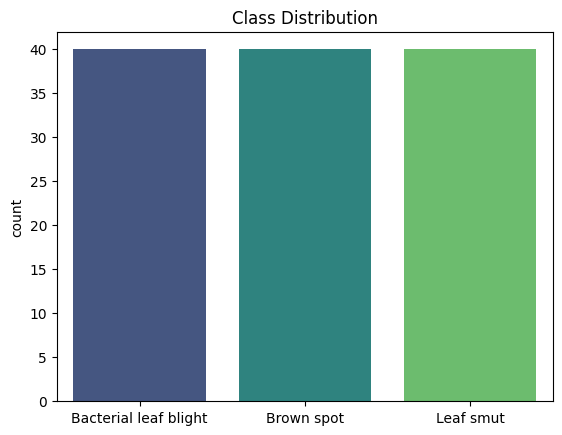

In [2]:
# --- CONFIGURATION ---
# '.' means "current directory". This works automatically on any computer.
DATA_DIR = './rice_data' 
BATCH_SIZE = 32
IMG_SIZE = 128

# --- AUGMENTATION ---
# Critical for small datasets to prevent overfitting
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- LOAD DATA ---
if not os.path.exists(DATA_DIR):
    print(f"❌ ERROR: Folder '{DATA_DIR}' not found!")
    print("Please make sure the 'rice_data' folder is in the same directory as this notebook.")
else:
    full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

    # Split 80% Train / 20% Test
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_data, test_data = random_split(full_dataset, [train_size, test_size])

    # Apply clean transform to test set
    test_data.dataset.transform = test_transform

    # Loaders
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    classes = full_dataset.classes
    print(f"✅ Data Loaded Successfully from local folder.")
    print(f"   Classes: {classes}")
    print(f"   Training: {len(train_data)} | Testing: {len(test_data)}")

    # Visual Check
    sns.countplot(x=[classes[label] for _, label in full_dataset.samples], palette="viridis")
    plt.title("Class Distribution")
    plt.show()

## The Model (RiceResNet)
This is the upgraded architecture. It uses Residual Blocks and Batch Normalization.

In [3]:
class RiceResBlock(nn.Module):
    """
    Residual Block with Batch Normalization.
    Prevents 'Vanishing Gradient' problem, allowing for deeper learning.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(RiceResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # <--- The Residual Connection
        out = F.relu(out)
        return out

class RiceResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(RiceResNet, self).__init__()
        # Initial Processing
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Layers
        self.layer1 = RiceResBlock(64, 64)
        self.layer2 = RiceResBlock(64, 128, stride=2)
        self.layer3 = RiceResBlock(128, 256, stride=2)

        # Classification Head
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x) # We will hook into this layer for Grad-CAM
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = RiceResNet(num_classes=len(classes)).to(DEVICE)
print("✅ Model Architecture Created (RiceResNet)")

✅ Model Architecture Created (RiceResNet)


## Professional Training Loop
Includes Learning Rate Scheduling and Checkpointing.

In [6]:
# --- HYPERPARAMETERS ---
EPOCHS = 40
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0

print("🚀 Starting Training...")

for epoch in range(EPOCHS):
    # --- TRAINING ---
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    # Progress Bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for inputs, labels in loop:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=loss.item())

    # --- VALIDATION ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # --- METRICS & SAVING ---
    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total
    avg_train_loss = running_loss / len(train_loader) # Use this variable name!
    avg_val_loss = val_loss / len(test_loader)

    history['train_loss'].append(avg_train_loss)
    history['val_acc'].append(val_acc)
    
    # Update Scheduler
    scheduler.step(val_acc)
    
    # Get Current Learning Rate
    current_lr = optimizer.param_groups[0]['lr']

    # Save Best Model Logic
    msg = ""
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_ricenet.pth')
        msg = "💾 Saved Best Model!"

    print(f"Epoch {epoch+1}: Loss {avg_train_loss:.4f} | Acc {val_acc:.2f}% | LR {current_lr:.6f} | {msg}")

print(f"\n🏆 Final Best Accuracy: {best_acc:.2f}%")

🚀 Starting Training...


Epoch 1/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Loss 0.9003 | Acc 45.83% | LR 0.001000 | 💾 Saved Best Model!


Epoch 2/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2: Loss 0.5070 | Acc 50.00% | LR 0.001000 | 💾 Saved Best Model!


Epoch 3/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3: Loss 0.4885 | Acc 50.00% | LR 0.001000 | 


Epoch 4/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4: Loss 0.4707 | Acc 50.00% | LR 0.001000 | 


Epoch 5/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5: Loss 0.3252 | Acc 45.83% | LR 0.001000 | 


Epoch 6/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6: Loss 0.3184 | Acc 50.00% | LR 0.001000 | 


Epoch 7/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7: Loss 0.2710 | Acc 54.17% | LR 0.001000 | 💾 Saved Best Model!


Epoch 8/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8: Loss 0.2571 | Acc 62.50% | LR 0.001000 | 💾 Saved Best Model!


Epoch 9/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9: Loss 0.2575 | Acc 87.50% | LR 0.001000 | 💾 Saved Best Model!


Epoch 10/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10: Loss 0.1763 | Acc 87.50% | LR 0.001000 | 


Epoch 11/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11: Loss 0.1343 | Acc 87.50% | LR 0.001000 | 


Epoch 12/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12: Loss 0.0894 | Acc 75.00% | LR 0.001000 | 


Epoch 13/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13: Loss 0.0728 | Acc 79.17% | LR 0.001000 | 


Epoch 14/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14: Loss 0.0683 | Acc 83.33% | LR 0.001000 | 


Epoch 15/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15: Loss 0.0497 | Acc 83.33% | LR 0.000500 | 


Epoch 16/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16: Loss 0.0397 | Acc 87.50% | LR 0.000500 | 


Epoch 17/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17: Loss 0.0657 | Acc 83.33% | LR 0.000500 | 


Epoch 18/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18: Loss 0.0387 | Acc 79.17% | LR 0.000500 | 


Epoch 19/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19: Loss 0.0645 | Acc 83.33% | LR 0.000500 | 


Epoch 20/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20: Loss 0.0659 | Acc 79.17% | LR 0.000500 | 


Epoch 21/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21: Loss 0.0771 | Acc 83.33% | LR 0.000250 | 


Epoch 22/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22: Loss 0.0305 | Acc 83.33% | LR 0.000250 | 


Epoch 23/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23: Loss 0.0329 | Acc 87.50% | LR 0.000250 | 


Epoch 24/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24: Loss 0.0375 | Acc 79.17% | LR 0.000250 | 


Epoch 25/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25: Loss 0.0195 | Acc 83.33% | LR 0.000250 | 


Epoch 26/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26: Loss 0.0144 | Acc 83.33% | LR 0.000250 | 


Epoch 27/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27: Loss 0.0265 | Acc 79.17% | LR 0.000125 | 


Epoch 28/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28: Loss 0.0393 | Acc 83.33% | LR 0.000125 | 


Epoch 29/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29: Loss 0.0201 | Acc 83.33% | LR 0.000125 | 


Epoch 30/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30: Loss 0.0117 | Acc 83.33% | LR 0.000125 | 


Epoch 31/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31: Loss 0.0155 | Acc 83.33% | LR 0.000125 | 


Epoch 32/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32: Loss 0.0253 | Acc 83.33% | LR 0.000125 | 


Epoch 33/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33: Loss 0.0147 | Acc 83.33% | LR 0.000063 | 


Epoch 34/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34: Loss 0.0115 | Acc 83.33% | LR 0.000063 | 


Epoch 35/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35: Loss 0.0155 | Acc 83.33% | LR 0.000063 | 


Epoch 36/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36: Loss 0.0096 | Acc 83.33% | LR 0.000063 | 


Epoch 37/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37: Loss 0.0105 | Acc 83.33% | LR 0.000063 | 


Epoch 38/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38: Loss 0.0159 | Acc 83.33% | LR 0.000063 | 


Epoch 39/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39: Loss 0.0143 | Acc 83.33% | LR 0.000031 | 


Epoch 40/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40: Loss 0.0157 | Acc 83.33% | LR 0.000031 | 

🏆 Final Best Accuracy: 87.50%


## Evaluation & Confusion Matrix

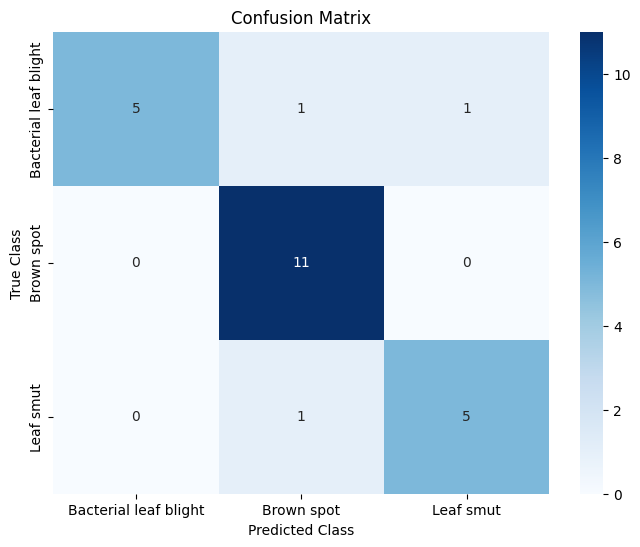


📋 Classification Report (Precision, Recall, F1-Score):

                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.71      0.83         7
           Brown spot       0.85      1.00      0.92        11
            Leaf smut       0.83      0.83      0.83         6

             accuracy                           0.88        24
            macro avg       0.89      0.85      0.86        24
         weighted avg       0.89      0.88      0.87        24



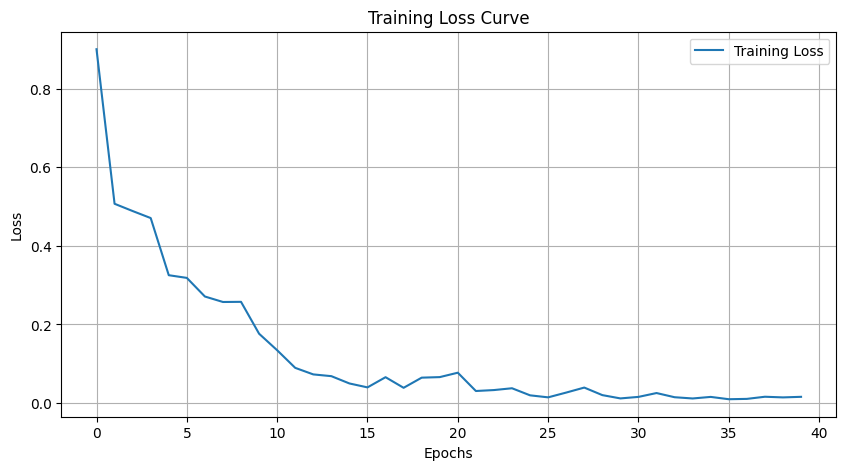

In [7]:
# 1. Load Best Weights
model.load_state_dict(torch.load('best_ricenet.pth'))
model.eval()

# 2. Get All Predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 3. Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# 4. Print Detailed Report
print("\n📋 Classification Report (Precision, Recall, F1-Score):\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# 5. Plot Loss History
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Advanced Explainability (Grad-CAM)

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


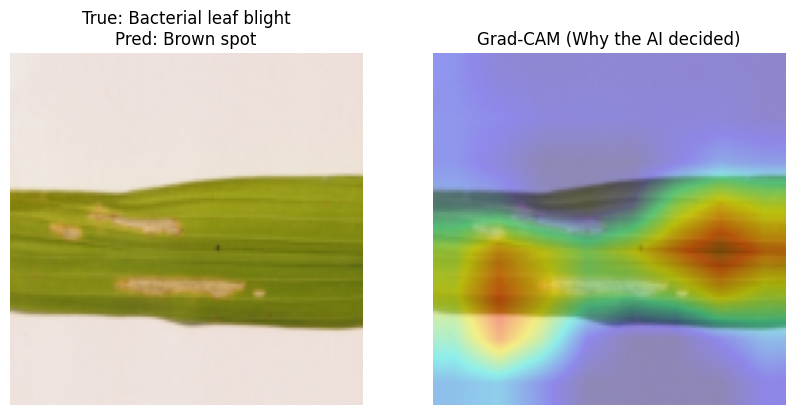

In [8]:
import cv2

def get_grad_cam(model, image_tensor, class_idx):
    """
    Generates a Grad-CAM heatmap for a given image and class.
    """
    # 1. Hook into the last convolutional layer (layer3)
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Target the last layer of the ResNet
    target_layer = model.layer3
    h1 = target_layer.register_backward_hook(backward_hook)
    h2 = target_layer.register_forward_hook(forward_hook)

    # 2. Forward Pass
    model.eval()
    # We need to enable grad for the input to backpropagate
    image_tensor = image_tensor.unsqueeze(0).to(DEVICE)
    output = model(image_tensor)

    # 3. Backward Pass
    model.zero_grad()
    score = output[0][class_idx]
    score.backward()

    # 4. Compute CAM
    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]
    
    # Global Average Pooling on gradients
    weights = np.mean(grads, axis=(1, 2))
    
    # Weighted combination of feature maps
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]
        
    # ReLU (Discard negative correlations)
    cam = np.maximum(cam, 0)
    
    # Normalize to 0-1
    cam = cv2.resize(cam, (128, 128))
    if np.max(cam) > 0:
        cam = cam / np.max(cam)
        
    h1.remove()
    h2.remove()
    return cam

# --- DEMO ---
# Get a random image from test set
idx = random.randint(0, len(test_data)-1)
img, label = test_data[idx]

# Get Prediction
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(DEVICE)).argmax(dim=1).item()

# Get Heatmap
heatmap = get_grad_cam(model, img, pred)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Un-normalize image for display
img_np = img.permute(1, 2, 0).numpy()
img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img_np = np.clip(img_np, 0, 1)

ax[0].imshow(img_np)
ax[0].set_title(f"True: {classes[label]}\nPred: {classes[pred]}")
ax[0].axis('off')

# Overlay Heatmap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
overlay = 0.6 * img_np + 0.4 * heatmap_colored

ax[1].imshow(overlay)
ax[1].set_title("Grad-CAM (Why the AI decided)")
ax[1].axis('off')

plt.show()